<a href="https://colab.research.google.com/github/Triple3A/Vehicle-Speed-Detection/blob/main/VECHILE_SPEED_DETECTION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before we start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi
## Install
!pip install -q --upgrade ultralytics supervision roboflow
!pip install --upgrade torch torchvision

Mounted at /content/drive
Mon Nov 25 23:02:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   38C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------

## Imports

In [2]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Configuration and load the dataset


In [3]:
!cp '/content/drive/MyDrive/Vehicle Speed Detection System/Data/bestn.pt' '/content/'

# Hyper Parameters

## Paths

In [4]:
DEPENDENT_PATH = "November_I-80_Davis/12_Nov_2024/Ashkan Videos/DJI_0004"
SOURCE_VIDEO_PATH = f"/content/drive/MyDrive/Vehicle Speed Detection System/Data/{DEPENDENT_PATH}.MP4"
TARGET_VIDEO_PATH = f"/content/drive/MyDrive/Vehicle Speed Detection System/Data/Results/Yolov11/Fine-tuned/{DEPENDENT_PATH}-result.mp4"
CONFIDENCE_THRESHOLD = 0.4
IOU_THRESHOLD = 0.5
# MODEL_NAME = "yolo11x.pt"
MODEL_NAME = "/content/bestn.pt"
MODEL_RESOLUTION = 1280

## Locations

### Santa Barbara

In [5]:
SOURCE_004 = np.array([
    [2470, 257],  #a
    [2710, 325], #b
    [1090,1568], #c              video1
    [760, 1330]  #d
])

SOURCE_008 = np.array([
    [2670, 257],  #a
    [2910, 325], #b
    [1100,1658], #c              video1
    [800, 1390]  #d
])

SOURCE_005 = np.array([
    [681, 124],
    [763, 137],
    [248, 662],
    [94, 587],
])

SOURCE_003 = np.array([
    [2528, 297],  #a
    [2780, 355], #b
    [1225,1568], #c              video1
    [820, 1380]  #d
])

SOURCE_007 = np.array([
    [2700, 307],  #a
    [2940, 375], #b
    [1180,1738], #c              video1
    [880, 1470]  #d
])

SOURCE_006 = np.array([
    [2010, 327],  #a
    [2250, 370], #b
    [555,2093], #c              video1
    [60, 1870]  #d
])

SOURCE_001 = np.array([
    [2160, 597],  #a
    [2360, 625], #b
    [1475,1913], #c              video1
    [1085, 1785]  #d
])


### 80_Davis_Sac

In [6]:
DAVIS_SAC_SOURCE_001 = np.array([
    [1785, 887],  #a
    [2040, 880], #b
    [2910,1793], #c
    [2385, 1880]  #d
])


DAVIS_SAC_SOURCE_002 = np.array([
    [1805, 887],  #a
    [2060, 880], #b
    [2930,1793], #c
    [2405, 1880]  #d
])


DAVIS_SAC_SOURCE_003 = np.array([
    [3300, 407],  #a
    [3750, 470], #b
    [2480,1913], #c
    [1700, 1360]  #d
])

DAVIS_SAC_SOURCE_004 = np.array([
    [3350, 427],  #a
    [3795, 520], #b
    [2520,1873], #c
    [1730, 1340]  #d
])


### I-80 Davis November

#### 12 Nov 2024

##### Ashkan

In [7]:
I_80_Ashkan_12_Nov_001 = np.array([
    [3570, 1187],  #a
    [3655, 1873], #b
    [125,1713], #c
    [305, 1050]
])

I_80_Ashkan_12_Nov_004 = np.array([
    [3590, 1187],  #a
    [3655, 1873], #b
    [175,1713], #c
    [355, 1050]
])

## Source

In [8]:
TARGET_WIDTH = 10.97
LINE_LENGTH = 3.6576

SOURCE_005_HEIGHT = 84.12
SANTA_BARBARA_COEFFICIENT = 6 * 4
DAVIS_SAC_80_COEFFICIENT = 4 * 4
I_80_DAVIS_COEFFICIENT = 7 * 2

TARGET_HEIGHT = LINE_LENGTH * I_80_DAVIS_COEFFICIENT#3.6576 * 4 * 4 #87.78 #84.12

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])


SOURCE = I_80_Ashkan_12_Nov_004.copy()


FIRST_LANE = np.array([
    SOURCE[0],
    (SOURCE[0] * 2 + SOURCE[1]) / 3,
    (SOURCE[3] * 2 + SOURCE[2]) / 3,
    SOURCE[3]
]).astype(int)

SECOND_LANE = np.array([
    FIRST_LANE[1],
    (SOURCE[0] + SOURCE[1] * 2) / 3,
    (SOURCE[3] + SOURCE[2] * 2) / 3,
    FIRST_LANE[2]
]).astype(int)

THIRD_LANE = np.array([
    SECOND_LANE[1],
    SOURCE[1],
    SOURCE[2],
    SECOND_LANE[2]
]).astype(int)

In [9]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)
# frame = next(frame_iterator)

## Annotated Frame

(2160, 3840, 3)


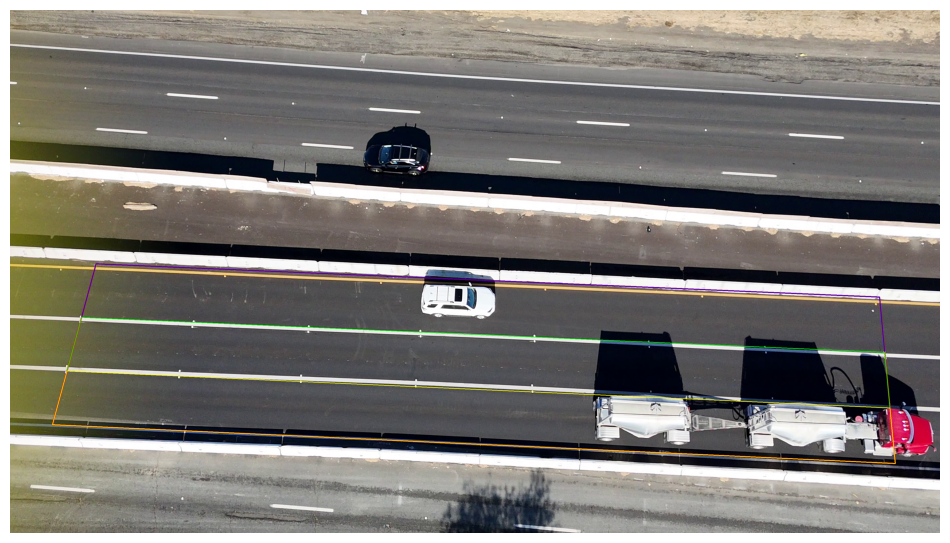

In [10]:
annotated_frame = frame.copy()
print(annotated_frame.shape)
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.RED, thickness=4)
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=FIRST_LANE, color=sv.Color.BLUE, thickness=2)
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SECOND_LANE, color=sv.Color.GREEN, thickness=2)
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=THIRD_LANE, color=sv.Color.YELLOW, thickness=2)
sv.plot_image(annotated_frame)


## Transform Perspective

In [11]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [12]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Process Video

In [13]:
import supervision as sv
help(sv)


Help on package supervision:

NAME
    supervision

PACKAGE CONTENTS
    annotators (package)
    assets (package)
    classification (package)
    config
    dataset (package)
    detection (package)
    draw (package)
    geometry (package)
    keypoint (package)
    metrics (package)
    tracker (package)
    utils (package)
    validators (package)

VERSION
    0.25.0

FILE
    /usr/local/lib/python3.10/dist-packages/supervision/__init__.py




#Use of Supervision Annotators.

In [14]:
# from google.colab import userdata
# import os, random, cv2
# import supervision as sv
# import IPython
# from inference import get_model
# from roboflow import Roboflow


# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')


# model_id = "trucks-r8hgo-vqo9i/4"
# model = get_model(model_id, ROBOFLOW_API_KEY)
# model

In [ ]:
export_data = {'id': [], 'class_name': [], 'speed': [], 'lane_number': [], 'count': []}

model = YOLO(MODEL_NAME)
CLASS_NAME_DICT = model.model.names
print(CLASS_NAME_DICT)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps#, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_optimal_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_optimal_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    # frame_resolution_wh=video_info.resolution_wh
)

polygon_zone_first_lane = sv.PolygonZone(
    polygon=FIRST_LANE,
    # frame_resolution_wh=video_info.resolution_wh
)

polygon_zone_second_lane = sv.PolygonZone(
    polygon=SECOND_LANE,
    # frame_resolution_wh=video_info.resolution_wh
)

polygon_zone_third_lane = sv.PolygonZone(
    polygon=THIRD_LANE,
    # frame_resolution_wh=video_info.resolution_wh
)

#is_detections_in_zone = polygon_zone.trigger(detections)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
frame_number = defaultdict(lambda: deque(maxlen=video_info.fps))


# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    current_frame = 0
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        current_frame += 1

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        # detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        #lane number
        is_detections_in_first_lane = polygon_zone_first_lane.trigger(detections)
        is_detections_in_second_lane = polygon_zone_second_lane.trigger(detections)
        is_detections_in_third_lane = polygon_zone_third_lane.trigger(detections)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            frame_number[tracker_id].append(current_frame)
            coordinates[tracker_id].append(y)

        # format labels
        labels = []
        lane_number = 0
        for tracker_id, class_id, first_lane, second_lane, third_lane in zip(detections.tracker_id, detections.class_id, is_detections_in_first_lane, is_detections_in_second_lane, is_detections_in_third_lane):
            if len(coordinates[tracker_id]) < video_info.fps / 5:
                labels.append(f"#{tracker_id} {CLASS_NAME_DICT[class_id]}")
            else:
                #lane number
                if first_lane:
                    lane_number = 1
                elif second_lane:
                    lane_number = 2
                elif third_lane:
                    lane_number = 3
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = abs(frame_number[tracker_id][-1] - frame_number[tracker_id][0]) / video_info.fps #len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 2.237
                labels.append(f"{lane_number} {CLASS_NAME_DICT[class_id]} {int(speed)} mph")
                # Save data
                if tracker_id in export_data['id']:
                    if lane_number == 0:
                        continue
                    else:
                        index = export_data['id'].index(tracker_id)
                        if export_data['count'][index] <= video_info.fps / 2:
                            export_data['class_name'][index] = CLASS_NAME_DICT[class_id]
                            export_data['speed'][index] = speed
                            export_data['lane_number'][index] = lane_number
                            export_data['count'][index] += 1
                else:
                    export_data['id'].append(tracker_id)
                    export_data['class_name'].append(CLASS_NAME_DICT[class_id])
                    export_data['speed'].append(speed)
                    export_data['lane_number'].append(lane_number)
                    export_data['count'].append(1)

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

{0: 'car', 1: 'heavy_vehicle'}


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
 95%|█████████▌| 9279/9756 [17:30<00:51,  9.23it/s]

In [ ]:
import csv

field_names= ['id', 'class name', 'speed', 'lane number', 'count']

with open(f'/content/drive/MyDrive/Vehicle Speed Detection System/Data/Results/Yolov11/Fine-tuned/{DEPENDENT_PATH}-result.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(export_data.keys())
    writer.writerows(zip(*export_data.values()))